In [1]:
from os.path import join
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile

In [2]:
path='train/'

files = [f for f in listdir(path) if isfile(join(path, f))]

len(files)

202

In [3]:
import xml.etree.ElementTree as ET
import re


def xml2df(xml_data,i):
    #xml_data=re.sub(u"(\u2018|\u2019)", "'", xml_data)
    tree = ET.parse(xml_data) #Initiates the tree Ex: <user-agents>
    
    all_records = [] #This is our record list which we will convert into a dataframe
    headers = [] #Subchildren tags will be parsed and appended here
    record = []
    attrib=[]
    values=[]
    label=[]
    tex=""
    for elem in tree.iter(): #Begin looping through our root tree
        if(elem.tag!='PatientMatching' and elem.tag!='TAGS'):
            headers.append(elem.tag)
            record.append(elem.text)
            attrib.append(elem.attrib.get('met'))
            
    text = record[0]
    
    file = open("TEXT/"+str(i)+".txt","w+") 
    file.write(record[0])
    file.close() 
    
    all_records.append(text)
    for a in attrib[1:]:
        if(a == 'met'):
            label.append(1)
        else:
             label.append(0)
    all_records.append(label)
    all_records.append(i)
    return pd.DataFrame([all_records], columns=['text','label','name']) 

In [4]:
data = None
for file in files:
    #print(str(i)+"/"+str(len(files)), end='\r')
    df = xml2df(join(path,file),file.split(".")[0])
    if data is None: data = df
    else: data = data.append(df,ignore_index=True)
    
data = data.convert_objects(convert_numeric=True)

C:\Users\rezvanjoshaghani\AppData\Roaming\Python\Python36\site-packages\ipykernel\__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
data.head()

,text,label,name
0,\n\nRecord date: 2106-02-12\n\nCampbell Orthop...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1]",100
1,\n\nRecord date: 2079-05-12\n\n\n\n\n\nMERCY C...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",101
2,\n\nRecord date: 2120-09-19\n\nPersonal Data a...,"[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]",102
3,\n\nRecord date: 2067-11-24\n\n ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",103
4,\n\nRecord date: 2094-02-16\n\nJENNIFER BOOKER...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]",104


In [6]:
data['a1c']=data.label.map(lambda x: x[8])

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize

data['sen'] = data.text.map(lambda x: sent_tokenize(x.replace("\n",". ")))

In [8]:
def isgood(x):
    gs=""
    expr = re.compile('.*a1c.*')
    for s in x:
        w=word_tokenize(s)
        for a in w:  
            if re.match(expr,a.lower()):
                gs=gs+s
                break
    return gs
    

In [9]:
data['sen']=data.sen.map(lambda x: isgood(x) )

In [10]:
import re
def removeDates(s):
    expr = re.compile('\d{2}/\d{2}/\d{4}')
    line = re.sub(expr, '', s)
    return line

In [11]:
data['clean']=data.sen.map(lambda x: removeDates(x))
data.clean.head()

0    Hemoglobin A1C       10.20H  3.80-6.40 %      ...
1                                                     
2    A1c, CBC, Fe, TIBC, ferritin, SGOT, SGPT, alka...
3                                                     
4    Diabetes mellitus, most recent Hgb A1c 7.30 6/...
Name: clean, dtype: object

In [12]:
data['split']=data.clean.map(lambda x: word_tokenize(x.lower()))

In [13]:
import nltk
from sklearn import preprocessing
we = preprocessing.LabelEncoder()
pstemmer = nltk.lancaster.LancasterStemmer()

vocab  = set([pstemmer.stem(i) for x in data.split for i in x])

In [14]:
len(vocab)

1335

In [15]:
we.fit(list(vocab)) 

LabelEncoder()

In [16]:
data['ind'] = data.split.map(lambda x: [we.transform([pstemmer.stem(i)])[0] for i in x])

In [17]:
data.to_pickle("a1c-1.pkl")

In [18]:
from keras.preprocessing import sequence

data['lens'] = data.ind.map(lambda x: len(x))
maxlen = max(data.lens)
maxlen

Using TensorFlow backend.


347

In [19]:
#datac=datac.sample(frac=0.05)
train=data.sample(frac=0.8,random_state=200)
test=data.drop(train.index)

train.shape, test.shape

((162, 9), (40, 9))

In [20]:
X_train = sequence.pad_sequences(train.ind, maxlen=maxlen)
X_train = np.array([x.ravel() for x in X_train])

In [21]:
y_train = np.array([x for x in train.a1c])
y_train.shape

(162,)

In [22]:
import numpy
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing import sequence
import numpy as np
import random


model = Sequential()
model.add(Embedding(len(vocab), maxlen, input_length=X_train.shape[1]))
model.add(Dense(200, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 347, 347)          463245    
_________________________________________________________________
dense_1 (Dense)              (None, 347, 200)          69600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 347, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 653,346
Trainable params: 653,346
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
162/162 [==============================] - 6s 40ms/step - loss: 0.6660 - acc: 0.6914
Epoch 2/10
162/162 [==============================] - 5s 29ms/step - loss: 0.6590 - acc: 0.4691
Epoch 3/10
162/162 [==============================] - 5s 29ms/step - loss: 0.3698 - acc: 0.8457
Epoch 4/10
162/162 [==============================] - 5s 32ms/step - loss: 0.2366 - acc: 0.9198
Epoch 5/10
162/162 [==============================] - 5s 29ms/step - loss: 0.1434 - acc: 0.9815
Epoch 6/10
162/162 [==============================] - 4s 27ms/step - loss: 0.0744 - acc: 0.9877
Epoch 7/10
162/162 [==============================] - 5s 29ms/step - loss: 0.0574 - acc: 0.9877
Epoch 8/10
162/162 [==============================] - 5s 28ms/step - loss: 0.0420 - acc: 0.9877
Epoch 9/10
162/162 [==============================] - 5s 29ms/step - loss: 0.0302 - acc: 0.9877
Epoch 10/10
162/162 [==============================] - 5s 30ms/step - loss: 0.0225 - acc: 0.9938


In [24]:
model.save('Trained Models/model-a1c-1.h5')

In [25]:
X_test = sequence.pad_sequences(test.ind, maxlen=maxlen)
X_test = np.array([x.ravel() for x in X_test])

In [26]:
Y_test = np.array([x for x in test.a1c])
Y_test

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [27]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.295413959026
Test accuracy: 0.9


In [28]:
prediction = model.predict(np.array(X_test))
df=pd.DataFrame(columns=["pr", "lb"])

In [29]:
df.pr=list(prediction)
df.lb=list(Y_test)
df['res']=df.pr.map(lambda x: 1 if x>0.5 else 0)
df['id']=list(test.name)
df['idlb']=list(test.label.map(lambda x: x[8]))

In [30]:
df.head()

,pr,lb,res,id,idlb
0,[0.00129525],0,0,101,0
1,[0.00129525],0,0,107,0
2,[0.00129525],0,0,116,0
3,[0.00129525],0,0,121,0
4,[0.995972],1,1,125,1


In [31]:
i=0
a=0
for index, row in df.iterrows():
    if row.lb==1:
        a=a+1
        if (row.lb==row.res) :
            i=i+1
i/a

0.8

In [32]:
i=0
a=0
for index, row in df.iterrows():
    if row.lb==0:
        a=a+1
        if (row.lb==row.res) :
            i=i+1
i/a

0.96

In [33]:
from collections import defaultdict
import operator
from sklearn.metrics import accuracy_score, f1_score

I = [1,0]


f1_score(df.lb, df.res, labels=I, average='macro')

0.89010989010989006

In [34]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test, Y_test)

0.67500000000000004

In [35]:
guess = model.predict_classes(X_test)
guess = [g[0] for g in guess]
gold = Y_test
guess[:5], gold[:5]

([0, 0, 0, 0, 1], array([0, 0, 0, 0, 1], dtype=int64))

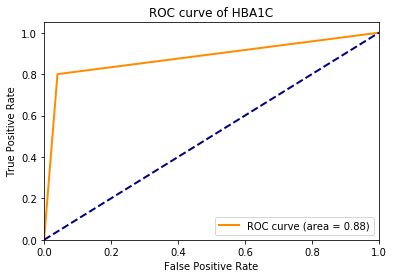

In [37]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 

x, y, _ = metrics.roc_curve(gold, guess)
auc = metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of HBA1C')
plt.legend(loc="lower right")
plt.show()

